# INM430 - Tiny DS Project Progress Report


***

Student Name: Qiqi Su 

Project Title: Do Airbnb Listing Prices affect London Housing Prices
***




## Part-1: Data source and domain description (maximum 150 words):

There are two separate datasets used for this analysis. 'listings.csv' (1) comes from insideairbnb.com, an independent company that scrapes data from live Airbnb listings across the world, with the most recent entry being July 2019. ‘UK House Price Index.csv’ (2) comes from data.london.gov.uk, which captures changes in the value of residential properties from January 1995 - August 2019.

There are some limitations in the dataset from insideairbnb.com. One of them is that the data only includes the ‘sticker price’, which is the advertised price, rather than the actual price paid by the guests. Nonetheless, this dataset still gives good indication for this analysis.

This analysis will be using relevant information from both datasets to identify if there is a correlation between the two datasets and a machine learning model will be built based on relevant correlation. 


***
***


## Part-2: Analysis Strategy and Plans (maximum 200 words):

Further visualisation on the merged dataset would allow me to understand both datasets better, identify outliers if present, compare the distribution to known distributions and time series analysis (such as comparing the price increase over the years between (1) and (2)).

The merged dataset will then allow me to analyse the correlation between the two, such as Pearson correlation (this might require the merged dataset to be normally distributed) and Spearman correlation. As far as I know, there isn’t a built in method to identify if there is cross-correlation. Therefore, I will create a function to shift the timeframe and find out if there is a such correlation. 

If there is a lagged correlation then the outcome from the above analysis would show that a change in the Airbnb listing price also results a change in the London housing price. Then, a multiple regression model will be built to predict what would the future London housing price would be based on Airbnb Listing Price.

If there isn’t a correlation between the Airbnb listing price and house price, then a Rank Correlation can be used to find out if any other features correlates with the output. This will be done using one of the popular methods, e.g Principle Component Analysis. 



***
***

## Part-3: Initial investigations on the data sources (maximum 150 words): 

Firstly, I dropped irrelevant columns from (1) and converted the type of columns that contain prices and dates to allow further analysis of these columns. 

There were 21,023 missing values dropped in the column that I took for the date stamp - ‘last_review’.

The dataset was then condensed further, to be able to group by ‘neighbourhood cleansed’ and ‘Year’ and take the mean values of the prices. 

I then followed similar steps to clean (2), and use the melt function so (2) is now in the long format. 

Next, I deleted the rows on (2) with year before 2011 as (1) only ranges from February 2011 - 2019. Then, both datasets are merged on ‘Year’ and ‘Area’. I have also filled the empty values in ‘Price_airbnb’ and ‘Total_airbnb’ with the mean value. 

I have kept two columns that contain prices from (1) as ‘Total_airbnb’ includes extra fees occurred such as cleaning fees, whereas the ‘Price_airbnb’ is just the advertised price. 



***
***

## Part-4: Python code for initial investigations

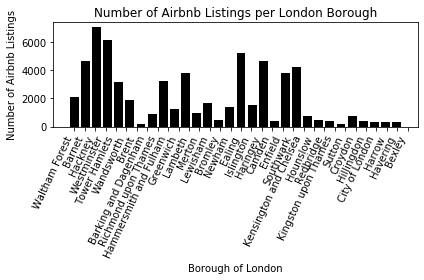

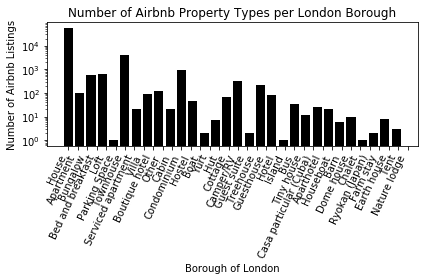

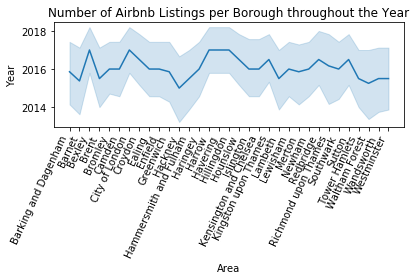

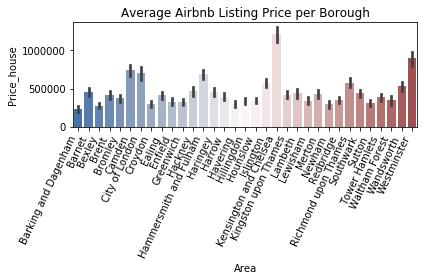

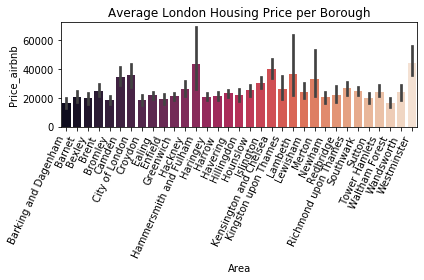

In [17]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

#import files
file=pd.read_csv('listings.csv',dtype={'weekly_price':str,'monthly_price':str,'license':str,'jurisdiction_names':str})
house=pd.read_csv('UK Average House Price.csv')
airbnb=file.loc[0:,['id', 'name','neighbourhood_cleansed', 'city', 'zipcode', 'smart_location', 'property_type',
                    'room_type', 'accommodates', 'price','weekly_price', 'monthly_price', 'security_deposit',
                    'cleaning_fee', 'extra_people','first_review','last_review']]
airbnb=airbnb.dropna(subset=['last_review'])

#cleaning airbnb dataset
#covert the dtype
airbnb[['price','weekly_price','monthly_price','security_deposit','cleaning_fee',
        'extra_people']]=airbnb[['price','weekly_price','monthly_price','security_deposit','cleaning_fee',
                                 'extra_people']].replace('[\$,]','',regex=True).astype(float)

#fill the missing price values
airbnb['price']=airbnb['price'].fillna(airbnb['price'].mean())
airbnb['cleaning_fee']=airbnb['cleaning_fee'].fillna(airbnb['cleaning_fee'].mean())

#convert dollar to pound
airbnb[['price','weekly_price','monthly_price']]=airbnb[['price','weekly_price','monthly_price']]*0.78

weekly_avg=(airbnb['weekly_price']/airbnb['price']).mean()
monthly_avg=(airbnb['monthly_price']/airbnb['price']).mean()

airbnb['weekly_price']=airbnb['weekly_price'].fillna(airbnb['price']*weekly_avg)
airbnb['monthly_price']=airbnb['monthly_price'].fillna(airbnb['price']*monthly_avg)

weekly=airbnb['price']*7
airbnb.insert(11,'weekly',weekly)

monthly=airbnb['price']*30
airbnb.insert(13,'monthly',monthly)

Price_airbnb=airbnb['price']*365
airbnb.insert(14,'Price_airbnb',Price_airbnb)

total_price=airbnb['Price_airbnb']+airbnb['cleaning_fee']
airbnb.insert(17,'Total_airbnb',total_price)

#change the format of date
airbnb['first_review']=pd.to_datetime(airbnb['first_review']).dt.strftime('%d/%m/%y')
airbnb['first_review']=pd.to_datetime(airbnb['first_review'])

airbnb['last_review']=pd.to_datetime(airbnb['last_review']).dt.strftime('%d/%m/%y')
airbnb['last_review']=pd.to_datetime(airbnb['last_review'])
airbnb=airbnb.sort_values(by=['last_review'],ascending=[True])

airbnb['property_type'].value_counts()
airbnb['neighbourhood_cleansed'].value_counts()

plt.hist(airbnb['neighbourhood_cleansed'],bins=30,rwidth=0.8,color='black',align='left')
plt.title('Number of Airbnb Listings per London Borough')
plt.xlabel('Borough of London')
plt.ylabel('Number of Airbnb Listings')
plt.xticks(rotation=65,horizontalalignment='right')
plt.tight_layout()
plt.show()

plt.hist(airbnb['property_type'],bins=30,rwidth=0.8,color='black',align='left',log=True)
plt.title('Number of Airbnb Property Types per London Borough')
plt.xlabel('Borough of London')
plt.ylabel('Number of Airbnb Listings')
plt.xticks(rotation=65,horizontalalignment='right')
plt.tight_layout()
plt.show()

#condence airbnb dataset further
airbnb1=airbnb
airbnb1['Year']=airbnb1['last_review'].dt.year
airbnb1=airbnb1.rename(columns={'neighbourhood_cleansed':'Area'})
airbnb1=airbnb1.groupby(['Area','Year']).mean().reset_index()
airbnb1=airbnb1.drop(columns=['id','accommodates','weekly_price','weekly','monthly_price','monthly',
                              'security_deposit','cleaning_fee','extra_people'])
airbnb1=airbnb1[['Price_airbnb','Total_airbnb','Area','Year']]

airbnb1.to_csv('test_airbnb.csv')

sns.lineplot(x=airbnb1['Area'],y=airbnb1['Year'])
plt.xticks(rotation=65,horizontalalignment='right')
plt.title('Number of Airbnb Listings per Borough throughout the Year')
plt.tight_layout()
plt.show()

#cleaning house dataset
house=house.drop(axis=0,index=0)
house=house.loc[:,:'Westminster']
house['Date']=pd.to_datetime(house['Date'])
house=house.melt(id_vars=['Date'],var_name='Area',value_name='Price')
house['Year']=house['Date'].dt.year
house=house.rename(columns={'Price':'Price_house'})
house['Price_house']=house['Price_house'].replace(',','',regex=True).astype(int)
house=house.groupby(['Area','Year']).mean().reset_index()
house=house[['Year','Area','Price_house']]

house=house.replace('Barking & Dagenham','Barking and Dagenham')
house=house.replace('Kensington & Chelsea','Kensington and Chelsea')
house=house.replace('Hammersmith & Fulham','Hammersmith and Fulham')

house=house[house.Year>=2011]

merged=pd.merge(house,airbnb1,how='outer',on=['Year','Area'])

merged['Price_airbnb']=merged['Price_airbnb'].fillna(merged['Price_airbnb'].mean())
merged['Total_airbnb']=merged['Total_airbnb'].fillna(merged['Total_airbnb'].mean())

merged.to_csv('test.csv')

sns.barplot(x=merged['Area'],y=merged['Price_house'],palette='vlag')
plt.xticks(rotation=65,horizontalalignment='right')
plt.title('Average Airbnb Listing Price per Borough')
plt.tight_layout()
plt.show()

sns.barplot(x=merged['Area'],y=merged['Price_airbnb'],palette='rocket')
plt.xticks(rotation=65,horizontalalignment='right')
plt.title('Average London Housing Price per Borough')
plt.tight_layout()
plt.show()
